# Setting up Variables and Functions

In [1]:
# Importing Pandas to create DataFrame
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sb

A_VALUE = 50 # remains the same
B_VALUE = 100 
C_VALUE = 300

A_VALUE_S = 50 # remains the same
B_VALUE_S = 0 
C_VALUE_S = 3000


BETA1 = 0.99 # decay factor for buyer
BETA2 = 15 # time difference 
BETA_S = 0.001 # 

### Calculating X and Reputation Score for Buyers/Sellers

In [2]:
'''
Account Age Increment: in Months 
Time_btwn_transactions: in hours
price: in ETH (range: 0.001 to 1)
'''

def calculateX_Buyer(old_x, time_btwn_transactions, price, BETA1, BETA2):
    beta1 = BETA1
    beta2 = BETA2
    temp1 = (time_btwn_transactions-12)/math.sqrt(beta2+(time_btwn_transactions-12)**2) #tolerance is 12 hours 
    
    if price>=2**112:
        price = 2**111
    temp2 = np.log(1+price/10**18) #price is in wei --> 18 decimals 
    
    if time_btwn_transactions >= 16*24:
        timePassed = 16 #in days 
    else:
        timePassed = math.floor(time_btwn_transactions/24)
    return old_x*(beta1**(timePassed)) + temp1*old_x + temp2*old_x


def calculateX_Seller(oldX, rep_score, rincoming, raverage, BETA_S):
    if (rincoming-raverage)==0:
        return oldX
    elif (rincoming-raverage)>0:
        return oldX + ((BETA_S/abs(rincoming-raverage)))*rep_score/1000*oldX
    elif (rincoming-raverage)<0:
        return oldX - ((BETA_S/abs(rincoming-raverage)))*rep_score/1000*oldX


# calculating reputation score 

def sigmoidal(x, A_VALUE, B_VALUE, C_VALUE):
    if x>100000000:
        x=10000000
#     return x
    a = A_VALUE
    b = B_VALUE
    c = C_VALUE
    temp1 = x-b
    temp2 = c + abs(x-b)*abs(x-b)
    temp3 = temp1/math.sqrt(temp2)
    temp4 = temp3 +1
    return a * temp4



    

# Simulation 1: Can a user artificially inflate his reputation score within a short period of time? 


**Considerations**
1. If so, what is the tolerance?
2. How long before the reputation can be increased?

**Notes**
1. Here, the attacker spams review every hour. 
2. Different values of the hyperparameters are explored to choose the ones best to resist such attacks. 


**Hyperparameters**
1. B_VALUE
2. C_VALUE
3. BETA1
4. BETA2

In [3]:
df = pd.DataFrame(columns = ['B_VALUE', 'C_VALUE', 'BETA1', 'BETA2', 'transactions', 'ETH', 'hours', 'days', 'FinalScore'])

def sim123(b, c,b1, b2, TIME_DIFFERENCE):
    #Variables to keep track of
    total_time_passed = 0.0
    user_x = 1
    user_rep = 0
    repList = []
    xList = []
    price =2322070000000000
    count = 0
    time_difference = TIME_DIFFERENCE
    while user_rep < 99 and count<1000:
        total_time_passed += time_difference    
        user_x = calculateX_Buyer(user_x, time_difference, price, b1, b2)
        xList.append(user_x)
        user_rep = sigmoidal(user_x, 50, b, c)
        repList.append(user_rep)
        count += 1
        
    return len(repList), (len(repList))*2322070000000000/(10**18), total_time_passed, total_time_passed/24, user_rep

#the user tries to inflate within a month and price 100wei, time between transactions is one hour
for b in range(100, 1000, 100):
    for c in range(100, 1000, 100):
        for b1 in [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]:
            for b2 in range(500, 5000, 500): 
                transactions, ETH, hours, days, user_rep = sim123(b, c, b1, b2, 1.0)
                df.loc[len(df)] = [b, c, b1, b2, transactions, ETH, hours, days, user_rep]
    
df

,B_VALUE,C_VALUE,BETA1,BETA2,transactions,ETH,hours,days,FinalScore
0,100.0,100.0,0.90,500.0,1000.0,2.32207,1000.0,41.666667,0.248140
1,100.0,100.0,0.90,1000.0,1000.0,2.32207,1000.0,41.666667,0.248140
2,100.0,100.0,0.90,1500.0,1000.0,2.32207,1000.0,41.666667,0.248140
3,100.0,100.0,0.90,2000.0,1000.0,2.32207,1000.0,41.666667,0.248140
4,100.0,100.0,0.90,2500.0,1000.0,2.32207,1000.0,41.666667,0.248140
...,...,...,...,...,...,...,...,...,...
7285,900.0,900.0,0.99,2500.0,1000.0,2.32207,1000.0,41.666667,0.027755
7286,900.0,900.0,0.99,3000.0,1000.0,2.32207,1000.0,41.666667,0.027755
7287,900.0,900.0,0.99,3500.0,1000.0,2.32207,1000.0,41.666667,0.027755
7288,900.0,900.0,0.99,4000.0,1000.0,2.32207,1000.0,41.666667,0.027755


In [4]:
df.to_csv('Simulation_1a_1Hour_New_Equation.csv')

<Axes: xlabel='BETA2', ylabel='FinalScore'>

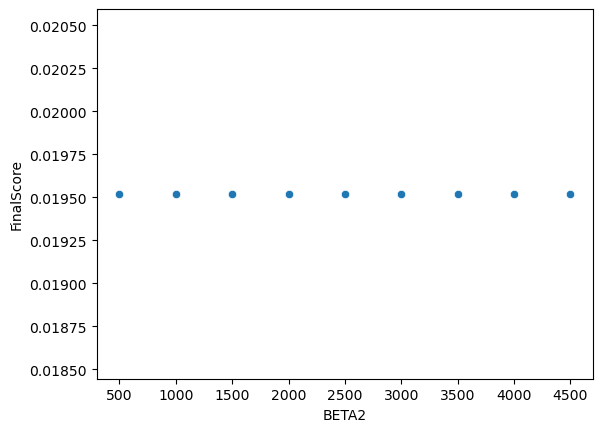

In [5]:
cleaned = df.loc[(df['C_VALUE'] == 500) & (df['B_VALUE'] == 800) & (df['BETA1']==0.99)]
sb.scatterplot(x=cleaned["BETA2"], y=cleaned["FinalScore"])

<Axes: xlabel='B_VALUE', ylabel='FinalScore'>

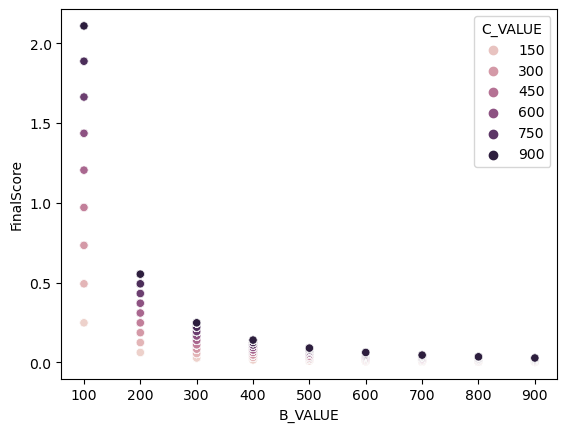

In [6]:
sb.scatterplot(x=df["B_VALUE"], y=df["FinalScore"], hue=df["C_VALUE"])

<Axes: xlabel='C_VALUE', ylabel='FinalScore'>

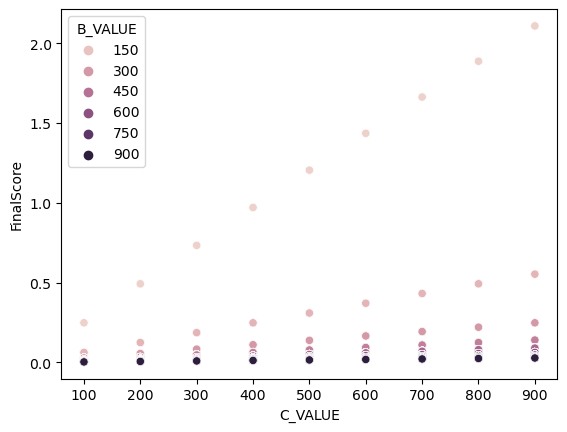

In [7]:
sb.scatterplot(x=df["C_VALUE"], y=df["FinalScore"], hue=df["B_VALUE"])

<Axes: xlabel='BETA1', ylabel='FinalScore'>

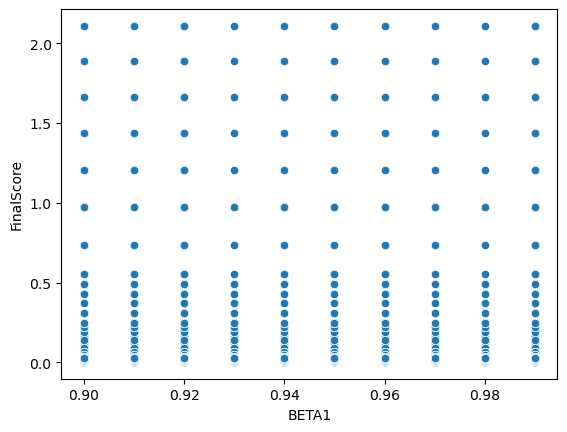

In [8]:
sb.scatterplot(x=df["BETA1"], y=df["FinalScore"])

<Axes: xlabel='BETA2', ylabel='FinalScore'>

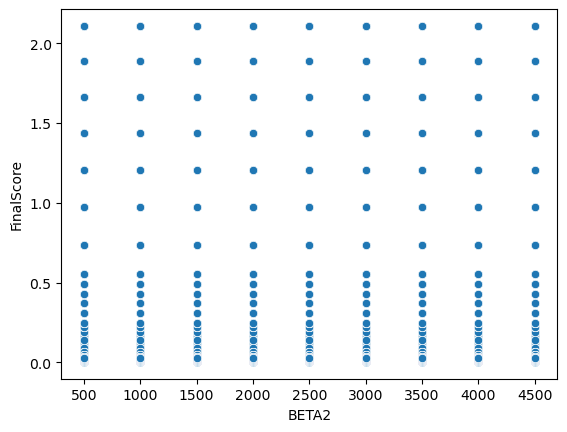

In [9]:
sb.scatterplot(x=df["BETA2"], y=df["FinalScore"])

In [10]:
# if the user purchases different products each time 
df = pd.DataFrame(columns = ['B_VALUE', 'C_VALUE', 'BETA1', 'BETA2', 'transactions', 'ETH', 'hours', 'days', 'FinalScore'])

def sim123(b, c,b1, b2, TIME_DIFFERENCE):
    #Variables to keep track of
    total_time_passed = 0.0
    user_x = 1
    user_rep = 0
    repList = []
    xList = []
    price =2322070000000000
    count = 0
    time_difference = TIME_DIFFERENCE
    while user_rep < 99 and count<1000:
        total_time_passed += time_difference    
        user_x = calculateX_Buyer(user_x, time_difference, price, b1, b2)
        xList.append(user_x)
        user_rep = sigmoidal(user_x, 50, b, c)
        repList.append(user_rep)
        count += 1
        
    return len(repList), (len(repList))*2322070000000000/(10**18), total_time_passed, total_time_passed/24, user_rep

#the user tries to inflate within a month and price 100wei, time between transactions is one hour
for b in range(100, 1000, 100):
    for c in range(100, 1000, 100):
        for b1 in [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]:
            for b2 in range(500, 5000, 500): 
                transactions, ETH, hours, days, user_rep = sim123(b, c, b1, b2, 12.0)
                df.loc[len(df)] = [b, c, b1, b2, transactions, ETH, hours, days, user_rep]
    
df

,B_VALUE,C_VALUE,BETA1,BETA2,transactions,ETH,hours,days,FinalScore
0,100.0,100.0,0.90,500.0,1000.0,2.32207,12000.0,500.0,0.306772
1,100.0,100.0,0.90,1000.0,1000.0,2.32207,12000.0,500.0,0.306772
2,100.0,100.0,0.90,1500.0,1000.0,2.32207,12000.0,500.0,0.306772
3,100.0,100.0,0.90,2000.0,1000.0,2.32207,12000.0,500.0,0.306772
4,100.0,100.0,0.90,2500.0,1000.0,2.32207,12000.0,500.0,0.306772
...,...,...,...,...,...,...,...,...,...
7285,900.0,900.0,0.99,2500.0,1000.0,2.32207,12000.0,500.0,0.028390
7286,900.0,900.0,0.99,3000.0,1000.0,2.32207,12000.0,500.0,0.028390
7287,900.0,900.0,0.99,3500.0,1000.0,2.32207,12000.0,500.0,0.028390
7288,900.0,900.0,0.99,4000.0,1000.0,2.32207,12000.0,500.0,0.028390


In [11]:
df.to_csv('Simulation_1b_1Hour_New_Equation.csv')

# Simulation 2: Can a user artificially inflate his reputation score within a short period of time? 


**Considerations**
1. If so, what is the tolerance?
2. How long before the reputation can be increased?

**Notes**
1. Here, the attacker spams review every 24 hours. 
2. Different values of the hyperparameters are explored to choose the ones best to resist such attacks. 


**Hyperparameters**
1. B_VALUE
2. C_VALUE
3. BETA1
4. BETA2
5. BETA3
6. BETA4

In [43]:
df = pd.DataFrame(columns = ['B_VALUE', 'C_VALUE', 'BETA1', 'BETA2', 'transactions', 'ETH', 'hours', 'days', 'FinalScore'])

#the user tries to inflate within a month and price 100wei, time between transactions is one hour
for b in range(100, 1000, 100):
    for c in range(100, 1000, 100):
        for b1 in [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]:
            for b2 in range(500, 5000, 500): 
                transactions, ETH, hours, days, user_rep = sim123(b, c, b1, b2, 24.0)
                df.loc[len(df)] = [b, c, b1, b2, transactions, ETH, hours, days, user_rep]
    
df

,B_VALUE,C_VALUE,BETA1,BETA2,transactions,ETH,hours,days,FinalScore
0,100.0,100.0,0.90,500.0,16.0,0.037153,384.0,16.0,99.393160
1,100.0,100.0,0.90,1000.0,22.0,0.051086,528.0,22.0,99.149674
2,100.0,100.0,0.90,1500.0,28.0,0.065018,672.0,28.0,99.281425
3,100.0,100.0,0.90,2000.0,34.0,0.078950,816.0,34.0,99.368659
4,100.0,100.0,0.90,2500.0,40.0,0.092883,960.0,40.0,99.368881
...,...,...,...,...,...,...,...,...,...
7285,900.0,900.0,0.99,2500.0,35.0,0.081272,840.0,35.0,99.806265
7286,900.0,900.0,0.99,3000.0,38.0,0.088239,912.0,38.0,99.813804
7287,900.0,900.0,0.99,3500.0,40.0,0.092883,960.0,40.0,99.397920
7288,900.0,900.0,0.99,4000.0,43.0,0.099849,1032.0,43.0,99.709568


In [44]:
df.to_csv("Simulation_2_24Hour_New_Equation.csv")

<Axes: xlabel='B_VALUE', ylabel='days'>

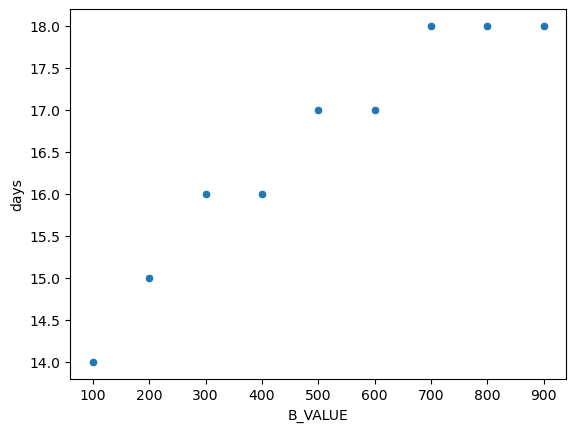

In [73]:
cleaned = df.loc[(df['C_VALUE'] == 100) & (df['BETA1'] == 0.99) & (df['BETA2']==500)]
sb.scatterplot(x=cleaned["B_VALUE"], y=cleaned["days"])

<Axes: xlabel='B_VALUE', ylabel='days'>

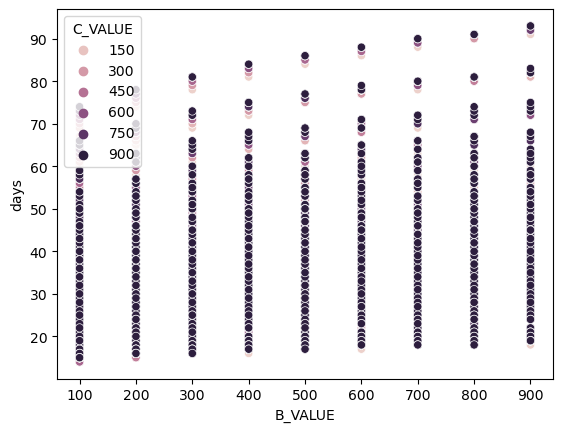

In [65]:
sb.scatterplot(x=df["B_VALUE"], y=df["days"], hue=df["C_VALUE"])

# Simulation 3: Can a user artificially inflate his reputation score within a short period of time? 


**Considerations**
1. If so, what is the tolerance?
2. How long before the reputation can be increased?

**Notes**
1. Here, the attacker spams review at random time intervals
2. Different values of the hyperparameters are explored to choose the ones best to resist such attacks. 


**Hyperparameters**
1. B_VALUE
2. C_VALUE
3. BETA1
4. BETA2
5. BETA3
6. BETA4

In [16]:
df = pd.DataFrame(columns = ['B_VALUE', 'C_VALUE', 'BETA1', 'BETA2', 'transactions', 'ETH', 'hours', 'days', 'FinalScore'])
rand_list = []
for i in range(10000):
    rand_list.append(np.random.randint(1, 168))
rowV=0

#the user tries to inflate within a month and price 100wei, time between transactions is one hour
for b in range(100, 1000, 100):
    for c in range(100, 1000, 100):
        for b1 in [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]:
            for b2 in range(500, 5000, 500): 
                transactions, ETH, hours, days, user_rep = sim123(b, c, b1, b2, rand_list[rowV])
                df.loc[len(df)] = [b, c, b1, b2, transactions, ETH, hours, days, user_rep]
                rowV+=1
    
df

,B_VALUE,C_VALUE,BETA1,BETA2,transactions,ETH,hours,days,FinalScore
0,100.0,100.0,0.90,500.0,10.0,0.023221,600.0,25.000000,99.840814
1,100.0,100.0,0.90,1000.0,12.0,0.027865,1452.0,60.500000,99.737106
2,100.0,100.0,0.90,1500.0,23.0,0.053408,506.0,21.083333,99.581306
3,100.0,100.0,0.90,2000.0,12.0,0.027865,1716.0,71.500000,99.581450
4,100.0,100.0,0.90,2500.0,13.0,0.030187,754.0,31.416667,99.588284
...,...,...,...,...,...,...,...,...,...
7285,900.0,900.0,0.99,2500.0,17.0,0.039475,748.0,31.166667,99.910529
7286,900.0,900.0,0.99,3000.0,1000.0,2.322070,11000.0,458.333333,0.027755
7287,900.0,900.0,0.99,3500.0,12.0,0.027865,1392.0,58.000000,99.920205
7288,900.0,900.0,0.99,4000.0,12.0,0.027865,1392.0,58.000000,99.858404


In [17]:
df.to_csv("Simulation_3_Arbitrary_Time_New_Equation.csv")

# Simulation 4: Can a user create multiple different accounts, to influence reviews? (spam attack with fully untrusted users)

**Considerations**
1. How tolerant is the system?
2. How many transactions are needed before you can significantly increase?
3. What parameters can we set?

**Notes**
1. Various values of hyperparameters are tested to see which will be most resistant

## Increase the review 

In [18]:
df = pd.DataFrame(columns = ['B_VALUE_S', 'C_VALUE_S', 'BETA_S','transactions','ETH', 'FinalReview', 'FinalX'])

def sim4(A_VALUE_S, B_VALUE_S, C_VALUE_S, BETA_S):
    #Variables to keep track of
    AVG_REVIEW = 0 #start 
    OLD_X = 1 #start
    R_INCOMING = 100
    REP_SCORE = 0 #start
    review_list = []
    count = 0
    review_list.append(AVG_REVIEW)

    while count<100000 and AVG_REVIEW<99:
        count += 1
        X = calculateX_Seller(OLD_X, REP_SCORE, R_INCOMING, AVG_REVIEW, BETA_S)
        AVG_REVIEW = sigmoidal(X, A_VALUE_S, B_VALUE_S, C_VALUE_S)
        OLD_X = X
        review_list.append(AVG_REVIEW)
    
    return len(review_list), AVG_REVIEW, X


#the user tries to inflate within a month and price 100wei, time between transactions is one hour
for b in range(100, 1000, 100):
    for c in range(100, 1000, 100):
        for beta_s in [0.01, 0.1, 1, 10, 20]:
                transactions, review, X = sim4(50, b, c, beta_s)
                df.loc[len(df)] = [b, c, beta_s, transactions, transactions*2322070000000000/(10**18), review, X]
    
df

,B_VALUE_S,C_VALUE_S,BETA_S,transactions,ETH,FinalReview,FinalX
0,100.0,100.0,0.01,100001.0,232.209322,0.253141,1.0
1,100.0,100.0,0.10,100001.0,232.209322,0.253141,1.0
2,100.0,100.0,1.00,100001.0,232.209322,0.253141,1.0
3,100.0,100.0,10.00,100001.0,232.209322,0.253141,1.0
4,100.0,100.0,20.00,100001.0,232.209322,0.253141,1.0
...,...,...,...,...,...,...,...
400,900.0,900.0,0.01,100001.0,232.209322,0.027816,1.0
401,900.0,900.0,0.10,100001.0,232.209322,0.027816,1.0
402,900.0,900.0,1.00,100001.0,232.209322,0.027816,1.0
403,900.0,900.0,10.00,100001.0,232.209322,0.027816,1.0


In [19]:
df.to_csv("Simulation_4a_Seller_New_Equation.csv")

<Axes: xlabel='B_VALUE_S', ylabel='FinalReview'>

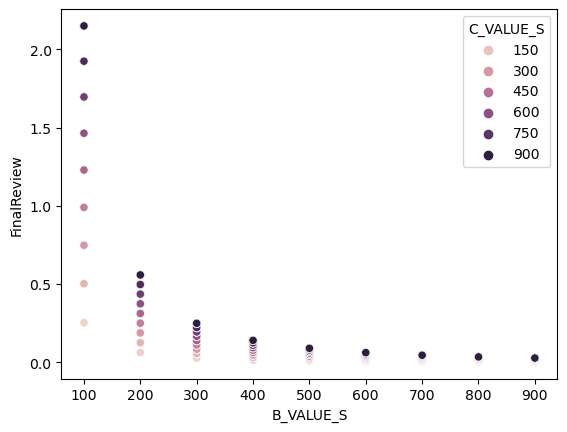

In [20]:
sb.scatterplot(x=df["B_VALUE_S"], y=df["FinalReview"], hue=df["C_VALUE_S"])

<Axes: xlabel='C_VALUE_S', ylabel='FinalReview'>

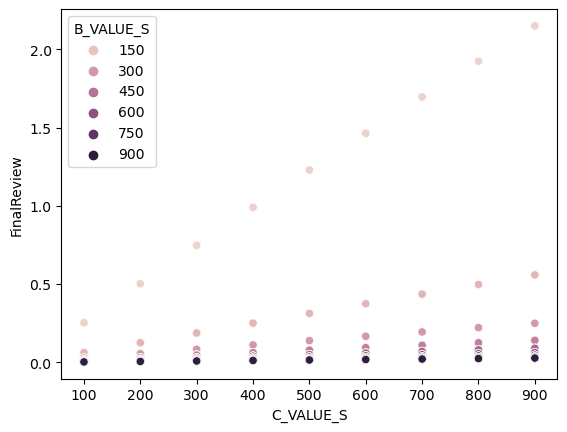

In [21]:
sb.scatterplot(x=df["C_VALUE_S"], y=df["FinalReview"], hue=df["B_VALUE_S"])

<Axes: xlabel='C_VALUE_S', ylabel='FinalReview'>

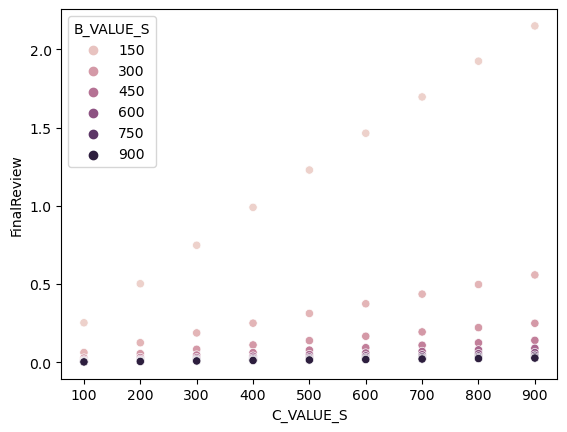

In [22]:
cleaned = df.loc[(df['BETA_S'] == 10)]
sb.scatterplot(x=cleaned["C_VALUE_S"], y=cleaned["FinalReview"], hue=df['B_VALUE_S'])

## To reduce the review

In [23]:
df = pd.DataFrame(columns = ['B_VALUE_S', 'C_VALUE_S', 'BETA_S','transactions','ETH', 'FinalReview'])

def sim4(A_VALUE_S, B_VALUE_S, C_VALUE_S, BETA_S):
    #Variables to keep track of
    AVG_REVIEW = 99 #start 
    OLD_X = 2000 #start
    R_INCOMING = 100
    REP_SCORE = 1
    review_list = []
    count = 0
    review_list.append(AVG_REVIEW)

    while count<10000 and AVG_REVIEW>=1:
        count += 1
        X = calculateX_Seller(OLD_X, REP_SCORE, R_INCOMING, AVG_REVIEW, BETA_S)
        AVG_REVIEW = sigmoidal(X, A_VALUE_S, B_VALUE_S, C_VALUE_S)
        OLD_X = X
        review_list.append(AVG_REVIEW)
    
    return len(review_list), AVG_REVIEW


#the user tries to inflate within a month and price 100wei, time between transactions is one hour
for b in range(100, 1000, 100):
    for c in range(100, 1000, 100):
        for beta_s in [0.01, 0.1, 1, 10, 20]:
                transactions, review = sim4(50, b, c, beta_s)
                df.loc[len(df)] = [b, c, beta_s, transactions, transactions*2322070000000000/(10**18), review]
    
df

,B_VALUE_S,C_VALUE_S,BETA_S,transactions,ETH,FinalReview
0,100.0,100.0,0.01,10001.0,23.223022,100.0
1,100.0,100.0,0.10,10001.0,23.223022,100.0
2,100.0,100.0,1.00,10001.0,23.223022,100.0
3,100.0,100.0,10.00,10001.0,23.223022,100.0
4,100.0,100.0,20.00,10001.0,23.223022,100.0
...,...,...,...,...,...,...
400,900.0,900.0,0.01,10001.0,23.223022,100.0
401,900.0,900.0,0.10,10001.0,23.223022,100.0
402,900.0,900.0,1.00,10001.0,23.223022,100.0
403,900.0,900.0,10.00,10001.0,23.223022,100.0


In [24]:
df.to_csv("Simulation_4b_Seller_New_Equation.csv")

<Axes: xlabel='B_VALUE_S', ylabel='FinalReview'>

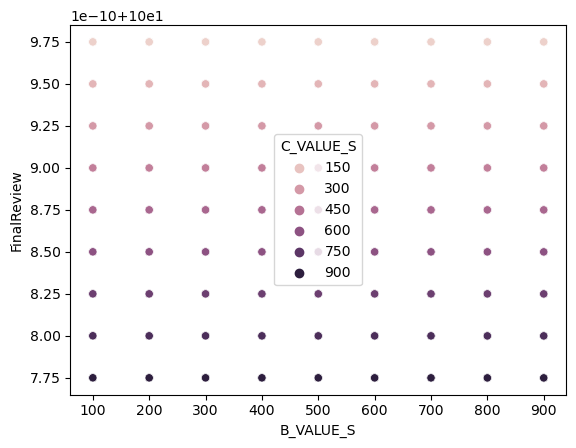

In [25]:
sb.scatterplot(x=df["B_VALUE_S"], y=df["FinalReview"], hue=df["C_VALUE_S"])

# Simulation 5: Can a user create multiple different accounts, to influence reviews? (spam attack with fully trusted users)

**Considerations**
1. How tolerant is the system?
2. How many transactions are needed before you can significantly increase?
3. What parameters can we set?

**Notes**
1. Various values of hyperparameters are tested to see which will be most resistant

## to increase review

In [26]:
df = pd.DataFrame(columns = ['B_VALUE_S', 'C_VALUE_S', 'BETA_S','transactions','ETH', 'FinalReview', 'FinalX'])

def sim5(A_VALUE_S, B_VALUE_S, C_VALUE_S, BETA_S):
    #Variables to keep track of
    AVG_REVIEW = 0 #start 
    OLD_X = 1 #start
    R_INCOMING = 100
    REP_SCORE = 99
    review_list = []
    count = 0
    review_list.append(AVG_REVIEW)

    while count<100000 and AVG_REVIEW<99:
        count += 1
        X = calculateX_Seller(OLD_X, REP_SCORE, R_INCOMING, AVG_REVIEW, BETA_S)
        AVG_REVIEW = sigmoidal(X, A_VALUE_S, B_VALUE_S, C_VALUE_S)
        OLD_X = X
        review_list.append(AVG_REVIEW)
    
    return len(review_list), AVG_REVIEW, X


#the user tries to inflate within a month and price 100wei, time between transactions is one hour
for b in range(100, 1000, 100):
    for c in range(100, 1000, 100):
        for beta_s in [0.01, 0.1, 1, 10, 20]:
                transactions, review, X = sim5(50, b, c, beta_s)
                df.loc[len(df)] = [b, c, beta_s, transactions, transactions*2322070000000000/(10**18), review, X]
    
df

,B_VALUE_S,C_VALUE_S,BETA_S,transactions,ETH,FinalReview,FinalX
0,100.0,100.0,0.01,100001.0,232.209322,0.261983,2.698090
1,100.0,100.0,0.10,46285.0,107.477010,99.026174,149.924330
2,100.0,100.0,1.00,4634.0,10.760472,99.185973,154.739000
3,100.0,100.0,10.00,469.0,1.089051,99.922582,279.492218
4,100.0,100.0,20.00,237.0,0.550331,99.828827,220.540990
...,...,...,...,...,...,...,...
400,900.0,900.0,0.01,100001.0,232.209322,0.027921,2.691964
401,900.0,900.0,0.10,68670.0,159.456547,99.008159,1048.365562
402,900.0,900.0,1.00,6873.0,15.959587,99.095892,1055.606749
403,900.0,900.0,10.00,693.0,1.609195,99.696572,1171.068923


In [27]:
df.to_csv("Simulation_5a_Seller_New_Equation.csv")

<Axes: xlabel='C_VALUE_S', ylabel='ETH'>

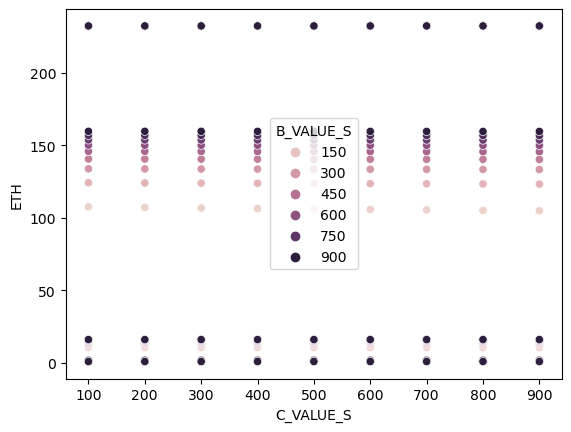

In [28]:
sb.scatterplot(x=df["C_VALUE_S"], y=df["ETH"], hue=df["B_VALUE_S"])

<Axes: xlabel='C_VALUE_S', ylabel='transactions'>

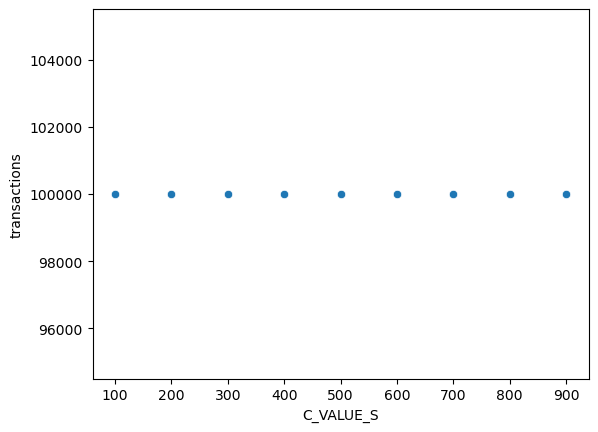

In [29]:
cleaned = df.loc[(df['BETA_S']==0.01)&(df['B_VALUE_S']==500)]
sb.scatterplot(x=cleaned["C_VALUE_S"], y=cleaned["transactions"])

### To reduce the score

In [30]:
df = pd.DataFrame(columns = ['B_VALUE_S', 'C_VALUE_S', 'BETA_S','transactions','ETH', 'FinalReview'])

def sim5(A_VALUE_S, B_VALUE_S, C_VALUE_S, BETA_S):
    #Variables to keep track of
    AVG_REVIEW = 99 #start 
    OLD_X = 2000 #start
    R_INCOMING = 1
    REP_SCORE = 99
    review_list = []
    count = 0
    review_list.append(AVG_REVIEW)

    while count<100000 and AVG_REVIEW>=1:
        count += 1
        X = calculateX_Seller(OLD_X, REP_SCORE, R_INCOMING, AVG_REVIEW, BETA_S)
        AVG_REVIEW = sigmoidal(X, A_VALUE_S, B_VALUE_S, C_VALUE_S)
        OLD_X = X
        review_list.append(AVG_REVIEW)
    
    return len(review_list), AVG_REVIEW


#the user tries to inflate within a month and price 100wei, time between transactions is one hour
for b in range(100, 1000, 100):
    for c in range(100, 1000, 100):
        for beta_s in [0.01, 0.1, 1, 10, 20]:
                transactions, review = sim5(50, b, c, beta_s)
                df.loc[len(df)] = [b, c, beta_s, transactions, transactions*2322070000000000/(10**18), review]
    
df

,B_VALUE_S,C_VALUE_S,BETA_S,transactions,ETH,FinalReview
0,100.0,100.0,0.01,100001.0,232.209322,99.993815
1,100.0,100.0,0.10,29967.0,69.585472,0.312463
2,100.0,100.0,1.00,2999.0,6.963888,0.669675
3,100.0,100.0,10.00,302.0,0.701265,0.038714
4,100.0,100.0,20.00,152.0,0.352955,0.008141
...,...,...,...,...,...,...
400,900.0,900.0,0.01,79668.0,184.994673,0.881148
401,900.0,900.0,0.10,7971.0,18.509220,0.086141
402,900.0,900.0,1.00,800.0,1.857656,0.624078
403,900.0,900.0,10.00,82.0,0.190410,0.775649


In [31]:
df.to_csv("Simulation_5b_Seller_New_Equation.csv")

<Axes: xlabel='B_VALUE_S', ylabel='FinalReview'>

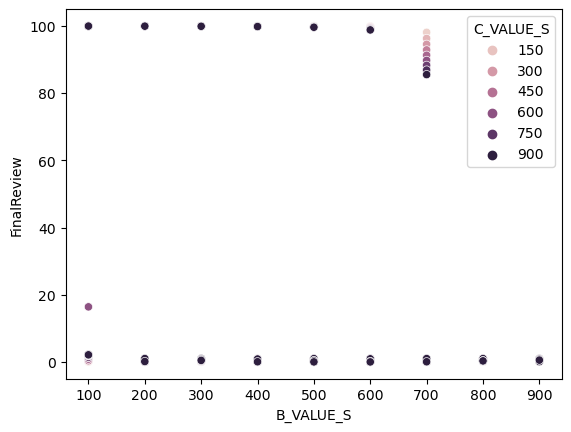

In [32]:
sb.scatterplot(x=df["B_VALUE_S"], y=df["FinalReview"], hue=df["C_VALUE_S"])

<Axes: xlabel='C_VALUE_S', ylabel='FinalReview'>

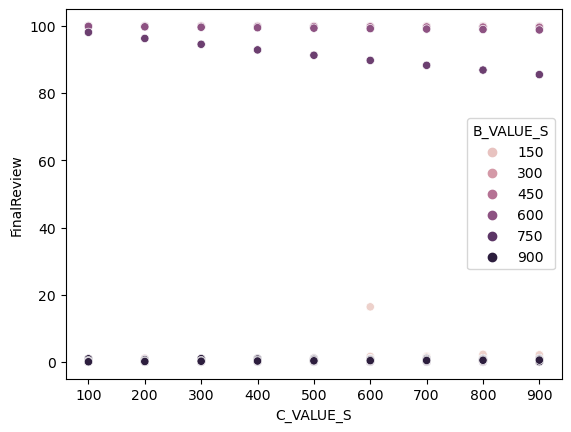

In [33]:
sb.scatterplot(x=df["C_VALUE_S"], y=df["FinalReview"], hue=df["B_VALUE_S"])

# Simulation 6: Can we use the same account, starting with no reputation, to gain reputation and leave a review?

**Considerations**
1. How tolerant is the system?
2. How many transactions is needed?

We know that we cannot deviate too far from the review score to affect the product review score. We also know we cannot have too much time in between the transaction. Additionally, we need to reduce the cost as much as possible for the attack. 

Let us say for each review left by the user, they receive a reward. Let us say they receive 10% of the product price multiplied by their reputation score. 

In [34]:
A_VALUE = 50 # remains the same
B_VALUE = 100 
C_VALUE = 300

A_VALUE_S = 50 # remains the same
B_VALUE_S = 300 
C_VALUE_S = 900

BETA_S = 0.1
BETA_1 = 0.99
BETA_2 = 4000

# to increase the review score

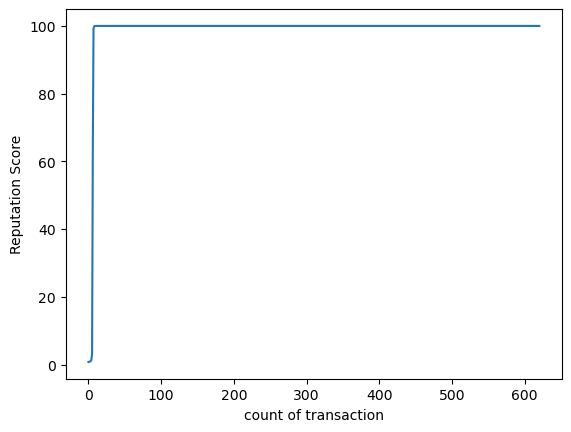

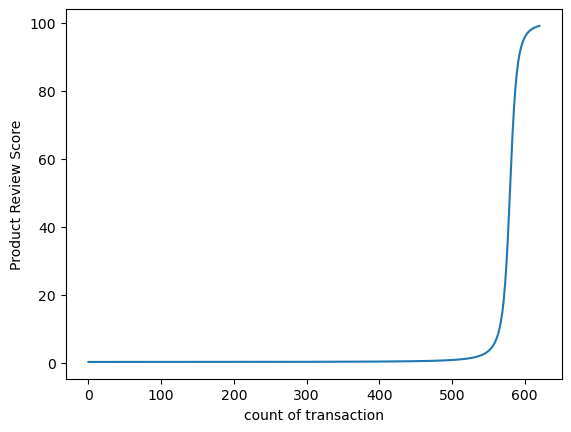

Final Reputation Score:  99.999999999925
Final Review Score:  99.01400499928702
Total Transactions needed:  621
Total number of days:  621.0
Total Cost of Purchasing Product:  1.44200547
Total Reward Obtained:  0.14273960173746983
Net Gain/Loss:  1.2992658682625302
Net Gain in USD:  2883.8682003982626


In [35]:
AVG_REVIEW = 0
X_SELLER = 1
REP_SCORE = 0
X_BUYER = 1
R_INCOMING = 0
PRICE = 2322070000000000
AVG_REVIEW_LIST = []
REP_SCORE_LIST = []
TOTAL_REWARD = 0
TIMEDIFF = 24.0

count = 0
while AVG_REVIEW<99 and count<1000000:
#     print("Seller X: ", X_SELLER)
#     print("Seller Review: ", AVG_REVIEW)
#     print("Buyer X: ", X_BUYER)
#     print("Buyer Reputation: ", REP_SCORE)
#     print("..................")
    
    # give the seller the review 
    X_SELLER = calculateX_Seller(X_SELLER, REP_SCORE, R_INCOMING, AVG_REVIEW, BETA_S)
    AVG_REVIEW = sigmoidal(X_SELLER, A_VALUE_S, B_VALUE_S, C_VALUE_S)
    AVG_REVIEW_LIST.append(AVG_REVIEW)
    
        
    X_BUYER = calculateX_Buyer(X_BUYER, TIMEDIFF, PRICE, BETA1, BETA2)
    REP_SCORE = sigmoidal(X_BUYER, A_VALUE, B_VALUE, C_VALUE)
    REP_SCORE_LIST.append(REP_SCORE)
    TOTAL_REWARD += 0.10 * PRICE * REP_SCORE/100
    
    R_INCOMING = AVG_REVIEW + 1
    count += 1
    
    

x = [i for i in range(len(REP_SCORE_LIST))]
y = REP_SCORE_LIST
plt.plot(x,y)
plt.xlabel("count of transaction")
plt.ylabel("Reputation Score")    
plt.show()
    
x = [i for i in range(len(AVG_REVIEW_LIST))]
y = AVG_REVIEW_LIST
plt.plot(x,y)
plt.xlabel("count of transaction")
plt.ylabel("Product Review Score")    
plt.show()

print("Final Reputation Score: ", REP_SCORE)
print("Final Review Score: ", AVG_REVIEW)
print("Total Transactions needed: ", count)
print("Total number of days: ", count*TIMEDIFF/24)
print("Total Cost of Purchasing Product: ", PRICE*count/(10**18))
print("Total Reward Obtained: ", TOTAL_REWARD/(10**18))
print("Net Gain/Loss: ", PRICE*count/(10**18)-TOTAL_REWARD/(10**18))
print("Net Gain in USD: ", 2000*PRICE*count/(10**18)-TOTAL_REWARD/(10**18))

# to reduce the review score

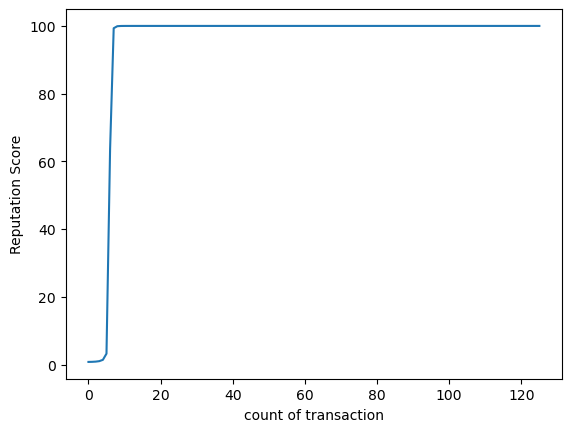

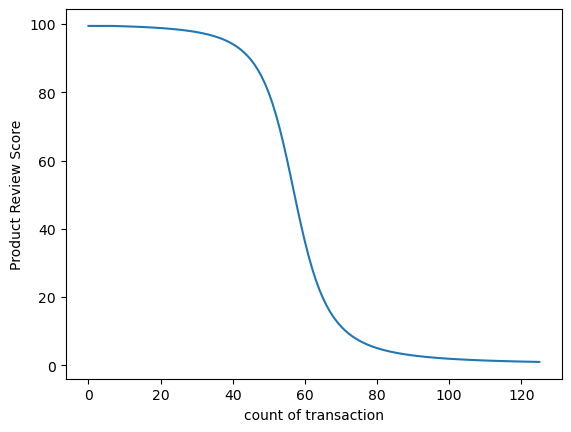

Final Reputation Score:  99.999999999925
Final Review Score:  0.9920218568303774
Total Transactions needed:  126
Total number of days:  126.0
Total Cost of Purchasing Product:  0.29258082
Total Reward Obtained:  0.02779713673755694
Net Gain/Loss:  0.26478368326244306
Net Gain in USD:  585.1338428632624


In [36]:
A_VALUE = 50 # remains the same
B_VALUE = 100 
C_VALUE = 300

A_VALUE_S = 50 # remains the same
B_VALUE_S = 300 
C_VALUE_S = 900

BETA_S = 0.1
BETA_1 = 0.99
BETA_2 = 4000

AVG_REVIEW = 99
X_SELLER = 500
REP_SCORE = 0
X_BUYER = 1
R_INCOMING = 90
PRICE = 2322070000000000
AVG_REVIEW_LIST = []
REP_SCORE_LIST = []
TOTAL_REWARD = 0
TIMEDIFF = 24

count = 0
while AVG_REVIEW>=1 and count<100000:
#     print("Seller X: ", X_SELLER)
#     print("Seller Review: ", AVG_REVIEW)
#     print("Buyer X: ", X_BUYER)
#     print("Buyer Reputation: ", REP_SCORE)
#     print("..................")
    
    # give the seller the review 
    X_SELLER = calculateX_Seller(X_SELLER, REP_SCORE, R_INCOMING, AVG_REVIEW, BETA_S)
    AVG_REVIEW = sigmoidal(X_SELLER, A_VALUE_S, B_VALUE_S, C_VALUE_S)
    AVG_REVIEW_LIST.append(AVG_REVIEW)
    
        
    X_BUYER = calculateX_Buyer(X_BUYER, TIMEDIFF, PRICE, BETA1, BETA2)
    REP_SCORE = sigmoidal(X_BUYER, A_VALUE, B_VALUE, C_VALUE)
    REP_SCORE_LIST.append(REP_SCORE)
    TOTAL_REWARD += 0.10 * PRICE * REP_SCORE/100
    
    R_INCOMING = AVG_REVIEW - 1
    count += 1
    
    

x = [i for i in range(len(REP_SCORE_LIST))]
y = REP_SCORE_LIST
plt.plot(x,y)
plt.xlabel("count of transaction")
plt.ylabel("Reputation Score")    
plt.show()
    
x = [i for i in range(len(AVG_REVIEW_LIST))]
y = AVG_REVIEW_LIST
plt.plot(x,y)
plt.xlabel("count of transaction")
plt.ylabel("Product Review Score")    
plt.show()

print("Final Reputation Score: ", REP_SCORE)
print("Final Review Score: ", AVG_REVIEW)
print("Total Transactions needed: ", count)
print("Total number of days: ", count*TIMEDIFF/24)
print("Total Cost of Purchasing Product: ", PRICE*count/(10**18))
print("Total Reward Obtained: ", TOTAL_REWARD/(10**18))
print("Net Gain/Loss: ", PRICE*count/(10**18)-TOTAL_REWARD/(10**18))
print("Net Gain in USD: ", 2000*PRICE*count/(10**18)-TOTAL_REWARD/(10**18))

# Visualization of Buyer


Number of transactions needed:  41
Number of hours:  984.0
Number of days:  41.0
Reputation Score:  99.34205760483725


Text(0, 0.5, 'Reputation score')

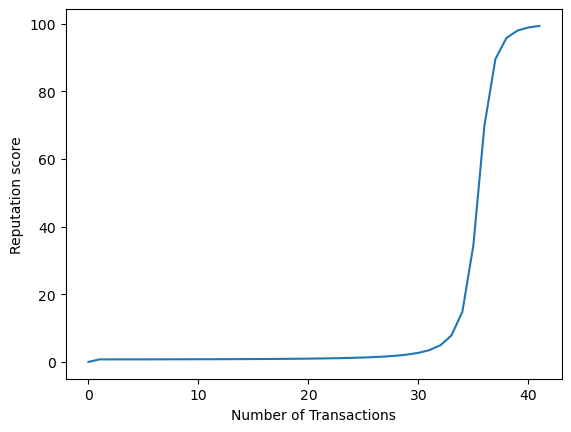

In [37]:
#declaring first time user parameters
user_age = 0
user_total_price_reviews = 0
total_reviews = 0
user_x = 1
user_rep = 0
price=2322070000000000.0 #5USD
# price = 443866700000000000.0 #1000USD
# price = 1000000000000000000.0 #2k USD
total_time_passed = 0.0
time_difference = 24.0

repList = []
xList = []
repList.append(0)
xList.append(0)

A_VALUE = 50 # remains the same
B_VALUE = 100
C_VALUE = 300
BETA1 = 0.95
BETA2 = 4000
count = 0

while user_rep < 99 and count<1000:
        total_time_passed += time_difference    
        user_x = calculateX_Buyer(user_x, time_difference, price, BETA1, BETA2)
        xList.append(user_x)
        user_rep = sigmoidal(user_x, A_VALUE, B_VALUE, C_VALUE)
        repList.append(user_rep)
        count += 1

        
print("Number of transactions needed: ", len(repList)-1)
print("Number of hours: ",(total_time_passed))
print("Number of days: ", (total_time_passed)/24)
print("Reputation Score: ", user_rep)


x = [i for i in range(len(repList))]
y = repList
plt.plot(x,y)
plt.xlabel("Number of Transactions")
plt.ylabel("Reputation score")

# Visualization Seller from Untrusted Buyers increasing the average review

Total Transactions need to reach review score 99:  1000000
Minimum Expenditure (ETH):  2322.07
Final Review score:  0.497512437810943


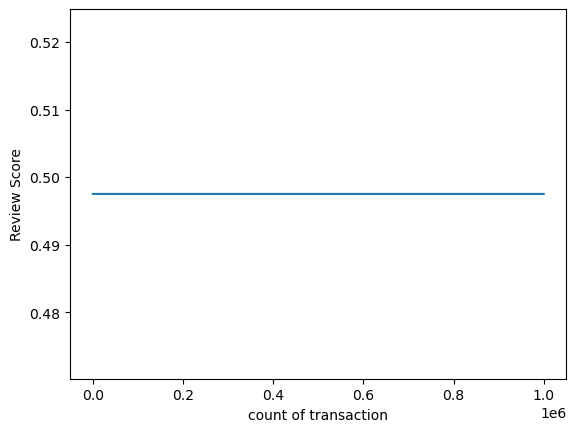

In [38]:
A_VALUE_S = 50 # remains the same
B_VALUE_S = 200 
C_VALUE_S = 800
BETA_S = 0.1
AVG_REVIEW = 0 #start 
OLD_X = 1 #start
R_INCOMING = 100
REP_SCORE = 0
review_list = []
count = 0

while count<1000000 and AVG_REVIEW<99:
    count += 1
    X = calculateX_Seller(OLD_X, REP_SCORE, R_INCOMING, AVG_REVIEW, BETA_S)
    AVG_REVIEW = sigmoidal(X, A_VALUE_S, B_VALUE_S, C_VALUE_S)
    OLD_X = X
    review_list.append(AVG_REVIEW)
    
x = [i for i in range(len(review_list))]
y = review_list
plt.plot(x,y)
plt.xlabel("count of transaction")
plt.ylabel("Review Score")
print("Total Transactions need to reach review score 99: ", len(review_list))
print("Minimum Expenditure (ETH): ", (len(review_list))*2322070000000000/(10**18))
print("Final Review score: ", AVG_REVIEW)

# Visualization Seller from untrusted buyers reducing the average review

Total Transactions need to reach review score 99:  1000000
Minimum Expenditure (ETH):  2322.07
Final Review score:  99.9938283033771


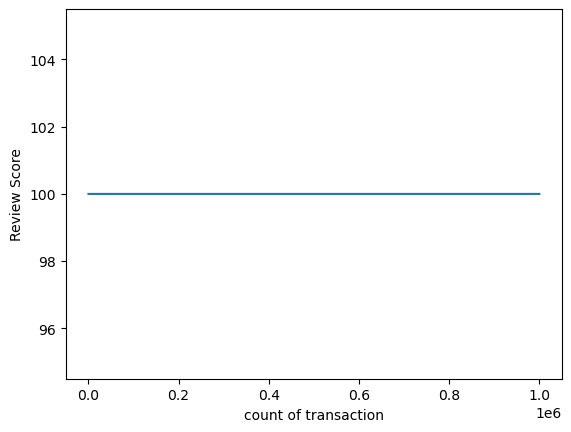

In [39]:
A_VALUE_S = 50 # remains the same
B_VALUE_S = 200 
C_VALUE_S = 800
BETA_S = 0.1
AVG_REVIEW = 99 #start 
OLD_X = 2000 #start
R_INCOMING = 1
REP_SCORE = 0
review_list = []
count = 0

while count<1000000 and AVG_REVIEW>=1:
    count += 1
    X = calculateX_Seller(OLD_X, REP_SCORE, R_INCOMING, AVG_REVIEW, BETA_S)
    AVG_REVIEW = sigmoidal(X, A_VALUE_S, B_VALUE_S, C_VALUE_S)
    OLD_X = X
    review_list.append(AVG_REVIEW)
    
x = [i for i in range(len(review_list))]
y = review_list
plt.plot(x,y)
plt.xlabel("count of transaction")
plt.ylabel("Review Score")
print("Total Transactions need to reach review score 99: ", len(review_list))
print("Minimum Expenditure (ETH): ", (len(review_list))*2322070000000000/(10**18))
print("Final Review score: ", AVG_REVIEW)

# Visualization Seller from trusted buyers increasing the average review

Total Transactions need to reach review score 99:  46284
Minimum Expenditure (ETH):  107.47468788
Final Review score:  99.0261736814449


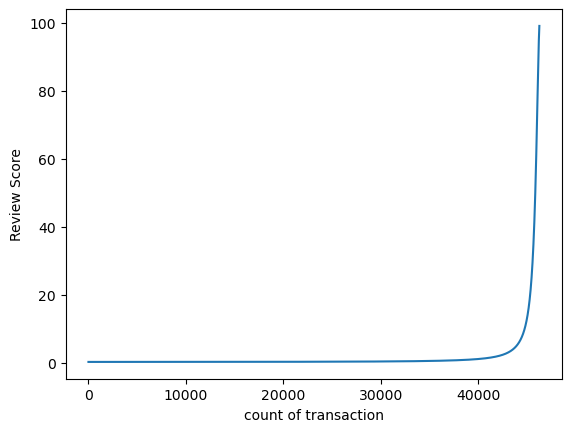

In [40]:
A_VALUE_S = 50 # remains the same
B_VALUE_S = 100 
C_VALUE_S = 100
BETA_S = 0.1
AVG_REVIEW = 0 #start 
OLD_X = 1 #start
R_INCOMING = 100
REP_SCORE = 99
review_list = []
count = 0

while count<100000 and AVG_REVIEW<99:
    count += 1
    X = calculateX_Seller(OLD_X, REP_SCORE, R_INCOMING, AVG_REVIEW, BETA_S)
    AVG_REVIEW = sigmoidal(X, A_VALUE_S, B_VALUE_S, C_VALUE_S)
    OLD_X = X
    review_list.append(AVG_REVIEW)
    
x = [i for i in range(len(review_list))]
y = review_list
plt.plot(x,y)
plt.xlabel("count of transaction")
plt.ylabel("Review Score")
print("Total Transactions need to reach review score 99: ", len(review_list))
print("Minimum Expenditure (ETH): ", (len(review_list))*2322070000000000/(10**18))
print("Final Review score: ", AVG_REVIEW)

# Visualization Seller from trusted buyers reducing the average review

Total Transactions need to reach review score 99:  29966
Minimum Expenditure (ETH):  69.58314962
Final Review score:  0.31246313764589084


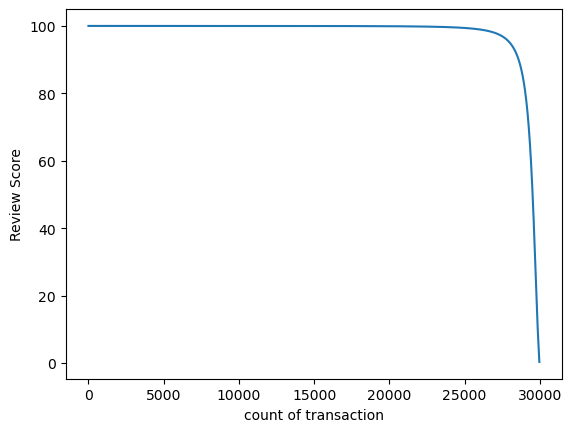

In [41]:
A_VALUE_S = 50 # remains the same
B_VALUE_S = 100 
C_VALUE_S = 100
BETA_S = 0.1
AVG_REVIEW = 99 #start 
OLD_X = 2000 #start
R_INCOMING = 1
REP_SCORE = 99
review_list = []
count = 0

while count<1000000 and AVG_REVIEW>=1:
    count += 1
    X = calculateX_Seller(OLD_X, REP_SCORE, R_INCOMING, AVG_REVIEW, BETA_S)
    AVG_REVIEW = sigmoidal(X, A_VALUE_S, B_VALUE_S, C_VALUE_S)
    OLD_X = X
    review_list.append(AVG_REVIEW)
    
x = [i for i in range(len(review_list))]
y = review_list
plt.plot(x,y)
plt.xlabel("count of transaction")
plt.ylabel("Review Score")
print("Total Transactions need to reach review score 99: ", len(review_list))
print("Minimum Expenditure (ETH): ", (len(review_list))*2322070000000000/(10**18))
print("Final Review score: ", AVG_REVIEW)